In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv("../data/cleaned.csv")

## RFM

**R — Recency (Recência)** : Há quanto tempo o cliente fez a última compra.
Clientes que compraram recentemente têm menor probabilidade de deixar de ser clientes.

**F — Frequency (Frequência)** : Quantas vezes o cliente comprou.
Clientes frequentes tendem a ter maior engajamento e fidelidade.

**M — Monetary (Valor Monetário)** :
Quanto dinheiro o cliente gastou no total.
Ajuda a identificar clientes que geram mais receita.

In [2]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = (
    df
    .groupby('CustomerID')
    .agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceNo': 'nunique',
        'Revenue': 'sum'
    })
    .reset_index()
)

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

rfm.head(5)


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1437.24
3,12349.0,19,1,1457.55
4,12350.0,310,1,294.40


In [3]:
rfm.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
CustomerID,4335.0,15298.8,1722.1,12346.0,13811.5,15297.0,16778.5,18287.0
Recency,4335.0,92.7,100.2,1.0,18.0,51.0,143.0,374.0
Frequency,4335.0,4.2,7.6,1.0,1.0,2.0,5.0,206.0
Monetary,4335.0,2015.5,8902.7,0.0,304.1,661.5,1631.5,279138.0


#### Analisando :
Recency : A média é perto de 93 dias, metade dos clientes passam mais de 51 dias ou mais sem comprar, o máximo de tempo que um cliente ficou sem comprar foi 374 dias.

Frequency : A média é perto de 4 vezes, metade dos clientes compram duas ou menos vezes, apenas 25% compra 5 vezes ou mais.

Monetary : A média de dinheiro deixado pelos clientes é 2015 euros (Por todas as compras), apenas 25% deixa mais que 1631 euros.

**Valores de média estão sendo influenciados por valores extremos, é mais eficaz verificar através de mediana e percentis**

## Análise exploratória de dados :

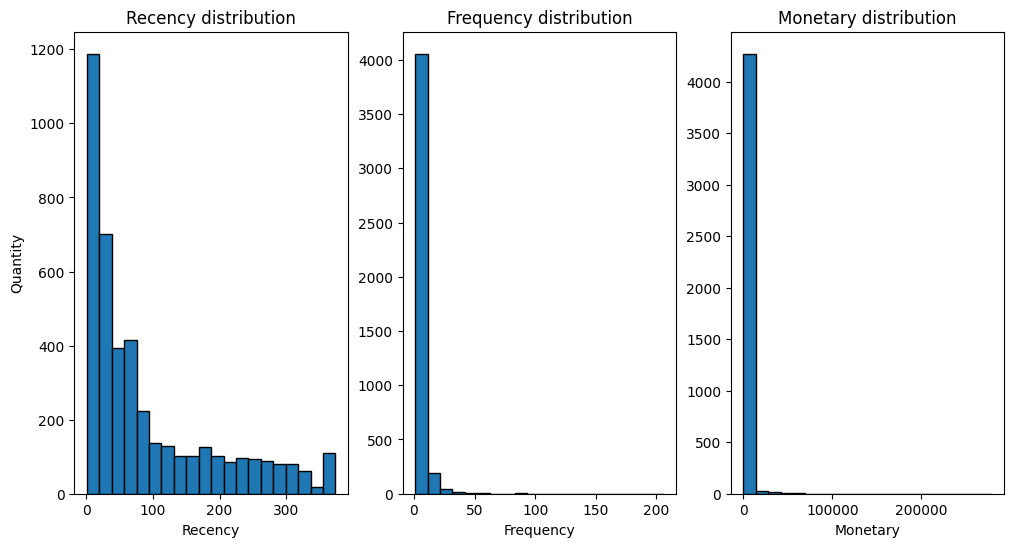

In [4]:
fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].hist(rfm['Recency'], bins=20, edgecolor='black')
ax[0].set_title('Recency distribution')
ax[0].set_ylabel('Quantity')
ax[0].set_xlabel('Recency')

ax[1].hist(rfm['Frequency'], bins=20, edgecolor='black')
ax[1].set_title('Frequency distribution')
ax[1].set_xlabel('Frequency')

ax[2].hist(rfm['Monetary'], bins=20, edgecolor='black')
ax[2].set_title('Monetary distribution')
ax[2].set_xlabel('Monetary')

plt.show()

Através destes gráficos de distribuição podemos também notar os outliers, ficam muito evidentes em Frequency e Monetary visto que temos uma alta concentração em valores baixos e um efeito **cauda longa** nestes gráficos, pouquíssimos registros altos, fazendo com que a **escala do gráfico se expanda excessivamente**, isso atrapalha muito a visualização, Estes registros não necessariamente estão errados (pode ter um registro onde uma pessoa gastou muito dinheiro ou é um cliente de muita frequência) então usaremos o **winsorize (filtrando) e guardaremos em outro dataframe**.

o winsorize consiste em **limitar os valores extremos de uma variável a determinados percentis** (por exemplo, 1% e 99%), substituindo os valores muito altos ou muito baixos pelos limites definidos. Essa abordagem preserva todos os registros do dataset, ao mesmo tempo em que reduz a influência dos outliers nas análises estatísticas e na visualização dos dados.


### Verificando os percentis extremos :

In [5]:
rfm['Monetary'].describe(percentiles=[.01, .05, .5, .9, .95, .99]).round(1)

count      4335.0
mean       2015.5
std        8902.7
min           0.0
1%           52.1
5%          110.9
50%         661.5
90%        3560.1
95%        5734.9
99%       18714.2
max      279138.0
Name: Monetary, dtype: float64

O mínimo é 3.75 e apenas 1% dos dados estão abaixo de 52, ou seja, é um **outlier** claro.

O máximo é 279138 99% dos dados estão abaixo de 18715.3, o valor máximo é 14 vezes maior que o maior dos outros 99% dos dados, então é com certeza um **outlier** que acaba distorcendo a escala do gráfico.

In [6]:
rfm['Frequency'].describe(percentiles=[.01, .05, .5, .9, .95, .99]).round(1)

count    4335.0
mean        4.2
std         7.6
min         1.0
1%          1.0
5%          1.0
50%         2.0
90%         9.0
95%        13.0
99%        30.0
max       206.0
Name: Frequency, dtype: float64

O máximo é 206 e 99% dos dados estão abaixo de 30 dias, então estes dados acabam distorcendo a escala da distribuição de Frequency

### Verificando através do boxplot :

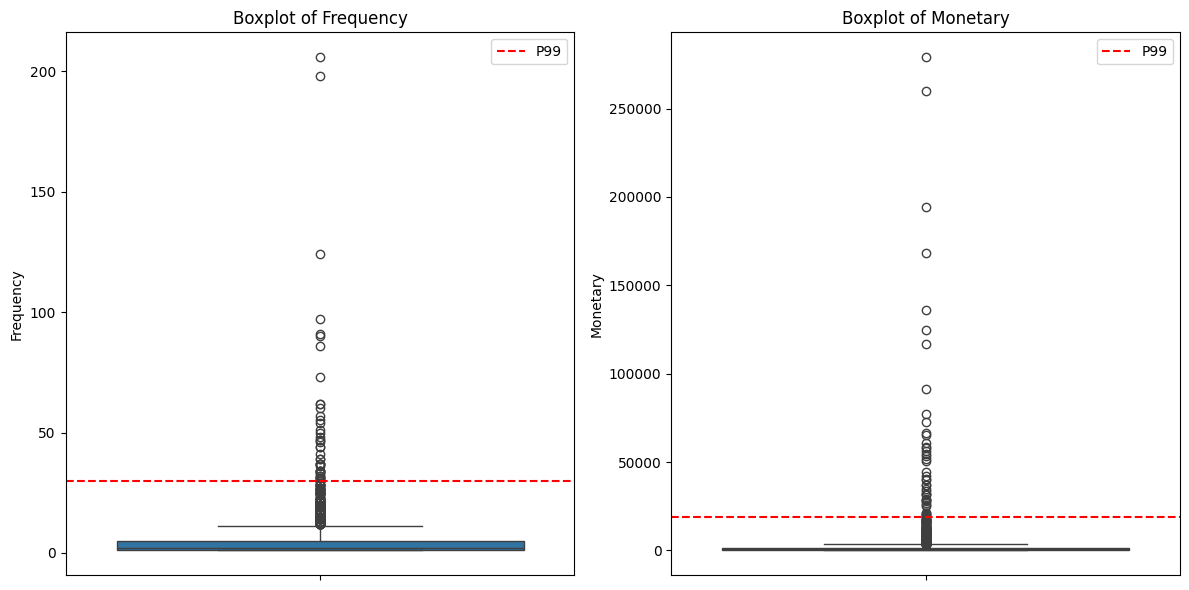

In [7]:
freq_p99 = rfm['Frequency'].quantile(0.99)
mon_p99 = rfm['Monetary'].quantile(0.99)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.boxplot(y='Frequency', data=rfm, ax=axes[0])
axes[0].axhline(freq_p99, color='red', linestyle='--', label='P99')
axes[0].set_title('Boxplot of Frequency')
axes[0].legend()

sns.boxplot(y='Monetary', data=rfm, ax=axes[1])
axes[1].axhline(mon_p99, color='red', linestyle='--', label='P99')
axes[1].set_title('Boxplot of Monetary')
axes[1].legend()

plt.tight_layout()
plt.show()


FIca explícito que há valores extremos tanto em Frequency quanto em Monetary, a linha tracejada em vermelho representa o **threshold (limiar) que separa os dados**, **abaixo ou bem nesta linha há 99% dos dados**.

### Winsorize :

In [8]:
def winsorize(series, lower=0.01, upper=0.99):
    return series.clip(
        lower=series.quantile(lower),
        upper=series.quantile(upper)
    )

rfm_w = rfm.copy()

for col in ['Recency', 'Frequency', 'Monetary']:
    rfm_w[col] = winsorize(rfm[col])

In [9]:
rfm_w.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
CustomerID,4335.0,15298.78,1722.08,12346.00,13811.5,15297.00,16778.50,18287.0
Recency,4335.0,92.65,100.08,1.00,18.0,51.00,143.00,369.0
Frequency,4335.0,3.99,4.85,1.00,1.0,2.00,5.00,30.0
Monetary,4335.0,1556.60,2679.93,52.07,304.1,661.52,1631.48,18714.2


### Plot sem valores extremos :

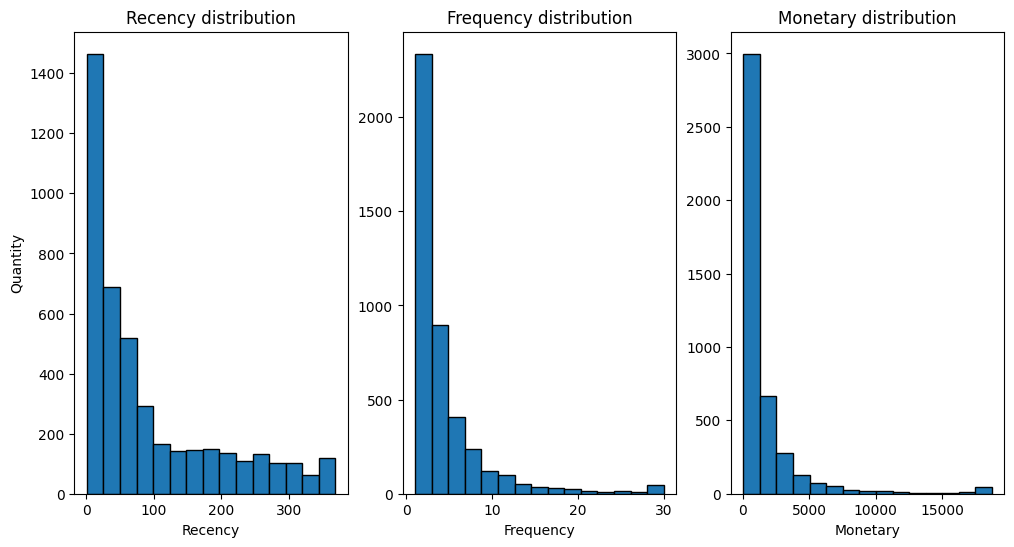

In [10]:
fig, ax = plt.subplots(1,3, figsize=(12,6))

ax[0].hist(rfm_w['Recency'], bins=15, edgecolor='black')
ax[0].set_title('Recency distribution')
ax[0].set_ylabel('Quantity')
ax[0].set_xlabel('Recency')

ax[1].hist(rfm_w['Frequency'], bins=15, edgecolor='black')
ax[1].set_title('Frequency distribution')
ax[1].set_xlabel('Frequency')

ax[2].hist(rfm_w['Monetary'], bins=15, edgecolor='black')
ax[2].set_title('Monetary distribution')
ax[2].set_xlabel('Monetary')

plt.show()

## Segmentação do RFM :
**Um estudo de como o RFM se distribui percentualmente** :

In [11]:
quantity_bins = list(range(0, 401, 50))
quantity_labels = [f"{quantity_bins[i]}-{quantity_bins[i+1]}"
                   for i in range(len(quantity_bins)-1)]

rfm['Recency_segment'] = pd.cut(
    rfm['Recency'],
    bins=quantity_bins,
    labels=quantity_labels,
    include_lowest=True,
    right=False
)

Recency_dist = (
    rfm['Recency_segment']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .sort_index()
)

Recency_dist


Recency_segment
0-50       48.88
50-100     19.54
100-150     7.34
150-200     6.94
200-250     5.72
250-300     5.35
300-350     3.46
350-400     2.77
Name: proportion, dtype: float64

A análise da distribuição de Recency mostra que **48,88%** dos clientes realizaram uma compra nos últimos 50 dias, indicando uma base significativa de clientes recentemente ativos. Em seguida, **19,54%** dos clientes compraram entre 50 e 100 dias atrás, o que reforça que quase **70%** da base teve alguma interação relativamente recente com a empresa.

A partir desse ponto, observa-se um comportamento decrescente consistente nas demais faixas de recency. À medida que o tempo desde a última compra aumenta, **a proporção de clientes diminui gradualmente**, formando uma **distribuição assimétrica com cauda longa**, típica de bases de clientes em e-commerce.

In [15]:
frequency_bins = list(range(0, 31, 5))
frequency_labels = [f"{frequency_bins[i]}-{frequency_bins[i+1]}"
                    for i in range(len(frequency_bins)-1)]

rfm['Frequency_segment'] = pd.cut(
    rfm['Frequency'],
    bins=frequency_bins,
    labels=frequency_labels,
    include_lowest=True,
    right=False
)

frequency_dist = (
    rfm['Frequency_segment']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .sort_index()
)

frequency_dist


Frequency_segment
0-5      75.36
5-10     16.69
10-15     4.66
15-20     1.84
20-25     0.84
25-30     0.61
Name: proportion, dtype: float64

A distribuição de Frequency indica que **75,36%** dos clientes realizaram até 5 compras, evidenciando que a maior parte da base possui baixo volume de transações. Em seguida, **16,69%** dos clientes efetuaram entre 5 e 10 compras, o que mostra que uma parcela menor apresenta um nível de engajamento mais recorrente.

A partir dessas duas faixas principais, observa-se novamente um comportamento **decrescente e gradual com comportamento de cauda longa.

In [16]:
monetary_bins = list(range(0, 20001, 2000))
monetary_labels = [f"{monetary_bins[i]}-{monetary_bins[i+1]}"
                   for i in range(len(monetary_bins)-1)]

rfm['Monetary_segment'] = pd.cut(
    rfm_w['Monetary'],
    bins=monetary_bins,
    labels=monetary_labels,
    include_lowest=True,
    right=False
)

monetary_dist = (
    rfm['Monetary_segment']
    .value_counts(normalize=True)
    .mul(100)
    .round(2)
    .sort_index()
)

monetary_dist


Monetary_segment
0-2000         79.63
2000-4000      12.04
4000-6000       3.62
6000-8000       1.64
8000-10000      0.74
10000-12000     0.58
12000-14000     0.30
14000-16000     0.14
16000-18000     0.28
18000-20000     1.04
Name: proportion, dtype: float64

A análise da distribuição de Monetary revela que **79,63%** dos clientes gastaram até 2.000 unidades monetárias, indicando que a grande maioria da base é composta por clientes de baixo valor individual. Em seguida, **12,04%** dos clientes estão na faixa entre 2.000 e 4.000, reforçando que mais de **90%** dos clientes concentram-se nas faixas iniciais de gasto.

A partir dessas categorias, observa-se novamente um comportamento decrescente e consistente nas faixas seguintes caracterizando uma distribuição fortemente assimétrica.

In [17]:
rfm.to_csv("../data/rfm.csv", index=False)